# <a id='toc1_'></a>[researchers](#toc0_)

In this notebook, the `researchers` table was created for the database, including various information about the researchers from pubmed enriched with the gender and its probability from `genderize` API.

**Table of contents**<a id='toc0_'></a>    
- [researchers](#toc1_)    
    - [Import researchers_df](#toc1_1_1_)    
  - [Data Cleansing](#toc1_2_)    
    - [Create a df of researchers](#toc1_2_1_)    
    - [Create the researchers ID: res_id](#toc1_2_2_)    
    - [Consider identifying the gender of the author based on their name, recognizing that this method may not always accurately reflect personal gender identity. Exercise sensitivity and be aware of the potential for inaccuracies in the process](#toc1_2_3_)    
    - [Include the gender columns](#toc1_2_4_)    
      - [Concatenate vertically all the files from the extraction](#toc1_2_4_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [79]:
# Libraries
import os
import pandas as pd

# Abstract Syntax Trees
import ast

# API tools
import requests

# progress bar
from tqdm.notebook import tqdm

# Multiprocessing
from joblib import Parallel, delayed, effective_n_jobs

# Functions
import sys
sys.path.append('../src')
from support_clean import *

### <a id='toc1_1_1_'></a>[Import researchers_df](#toc0_)

In [2]:
researchers = pd.read_csv('../data/researchers_df.csv')
researchers.head(2)

,Unnamed: 0,pub_id,authors,journal_id,first_auth,last_auth,auth_aff_list,first_auth_aff,last_auth_aff
0,0,38012702,"['Wu, Anbiao', 'Zhang, Jiyan']",101222974.0,"Wu, Anbiao","Zhang, Jiyan","['Beijing Institute of Basic Medical Sciences,...","Beijing Institute of Basic Medical Sciences, B...","Beijing Institute of Basic Medical Sciences, B..."
1,1,38012669,"['Zheng, Shengnan', 'Li, Yiquan', 'Song, Xiaom...",101222974.0,"Zheng, Shengnan","Liu, Huiqing","['Department of Pharmacology, School of Basic ...","Department of Pharmacology, School of Basic Me...","Department of Rehabilitation Medicine, The Sec..."


## <a id='toc1_2_'></a>[Data Cleansing](#toc0_)

In [3]:
df = researchers.copy()

In [4]:
to_drop = ['Unnamed: 0']
display(df.shape)
df = df.drop(columns=to_drop)
display(df.shape)

(61981, 9)

(61981, 8)

In [5]:
df = df.rename(columns={'ID': 'pub_id'})
df.head(2)

,pub_id,authors,journal_id,first_auth,last_auth,auth_aff_list,first_auth_aff,last_auth_aff
0,38012702,"['Wu, Anbiao', 'Zhang, Jiyan']",101222974.0,"Wu, Anbiao","Zhang, Jiyan","['Beijing Institute of Basic Medical Sciences,...","Beijing Institute of Basic Medical Sciences, B...","Beijing Institute of Basic Medical Sciences, B..."
1,38012669,"['Zheng, Shengnan', 'Li, Yiquan', 'Song, Xiaom...",101222974.0,"Zheng, Shengnan","Liu, Huiqing","['Department of Pharmacology, School of Basic ...","Department of Pharmacology, School of Basic Me...","Department of Rehabilitation Medicine, The Sec..."


### <a id='toc1_2_1_'></a>[Create a df of researchers](#toc0_)

In [6]:
# Transform the strings to lists again
df['authors'] = df['authors'].apply(ast.literal_eval)

In [7]:
# Create a row per author
df_authors = df.explode('authors')

In [8]:
df_authors[:5]

,pub_id,authors,journal_id,first_auth,last_auth,auth_aff_list,first_auth_aff,last_auth_aff
0,38012702,"Wu, Anbiao",101222974.0,"Wu, Anbiao","Zhang, Jiyan","['Beijing Institute of Basic Medical Sciences,...","Beijing Institute of Basic Medical Sciences, B...","Beijing Institute of Basic Medical Sciences, B..."
0,38012702,"Zhang, Jiyan",101222974.0,"Wu, Anbiao","Zhang, Jiyan","['Beijing Institute of Basic Medical Sciences,...","Beijing Institute of Basic Medical Sciences, B...","Beijing Institute of Basic Medical Sciences, B..."
1,38012669,"Zheng, Shengnan",101222974.0,"Zheng, Shengnan","Liu, Huiqing","['Department of Pharmacology, School of Basic ...","Department of Pharmacology, School of Basic Me...","Department of Rehabilitation Medicine, The Sec..."
1,38012669,"Li, Yiquan",101222974.0,"Zheng, Shengnan","Liu, Huiqing","['Department of Pharmacology, School of Basic ...","Department of Pharmacology, School of Basic Me...","Department of Rehabilitation Medicine, The Sec..."
1,38012669,"Song, Xiaomeng",101222974.0,"Zheng, Shengnan","Liu, Huiqing","['Department of Pharmacology, School of Basic ...","Department of Pharmacology, School of Basic Me...","Department of Rehabilitation Medicine, The Sec..."


### <a id='toc1_2_2_'></a>[Create the researchers ID: res_id](#toc0_)

In [9]:
# Create a list with the unique researchers
researchers_list = df_authors['authors']
display(len(researchers_list))
researchers_list = list(set(researchers_list))
display(len(researchers_list))

372016

228898

In [10]:
# Transform to df
researchers_df = pd.DataFrame(researchers_list)

In [11]:
researchers_df = researchers_df.rename(columns={0: 'researcher'})

In [12]:
# Create a column with the surnames
researchers_df['surname'] = [row.split(',')[0] for row in researchers_df['researcher']]

In [13]:
# Create a column with the names
erratic_names = []

def name_column(x): 
    '''
    '''
    try:
        if ',' in x:
            name = x.split(',')[1]
            return name
        elif len(x.split(' ')) == 2:
            name = x.split(' ')[0]
            return name
        elif len(x.split(' ')) > 2:
            return ''
        else: 
            erratic_names.append(x)
            return x
    except:
        erratic_names.append(x)
        return x

In [14]:
researchers_df['name'] = researchers_df['researcher'].apply(name_column)

In [15]:
researchers_df.head()

,researcher,surname,name
0,"Howe, Charles L",Howe,Charles L
1,"Sun, Hong-Shuo",Sun,Hong-Shuo
2,"Arroyo, Rafael",Arroyo,Rafael
3,"Gonçalves, Bruno",Gonçalves,Bruno
4,"Wall, Michael",Wall,Michael


In [16]:
# Create res_id
researchers_df['res_id'] = researchers_df.index

In [17]:
researchers_df.head()

,researcher,surname,name,res_id
0,"Howe, Charles L",Howe,Charles L,0
1,"Sun, Hong-Shuo",Sun,Hong-Shuo,1
2,"Arroyo, Rafael",Arroyo,Rafael,2
3,"Gonçalves, Bruno",Gonçalves,Bruno,3
4,"Wall, Michael",Wall,Michael,4


In [18]:
# Change the order of the columns
researchers_df = researchers_df[['res_id', 'researcher', 'surname', 'name']]

### <a id='toc1_2_3_'></a>[Consider identifying the gender of the author based on their name, recognizing that this method may not always accurately reflect personal gender identity. Exercise sensitivity and be aware of the potential for inaccuracies in the process](#toc0_)

**genderize.io** is a free API, but limited at 1000 requests by day.

    url = f'https://api.genderize.io/?name[]={name}'   

**The answer will be like this:**

    { "name": "peter",
      "gender": "male",
      "probability": 0.99,
      "count": 165452 }

In [ ]:
names = researchers_df['name']

In [ ]:
with open('../genderizer_api.txt', 'r') as file:
    genderized_api = file.read().strip()

In [ ]:
# Create a list of urls
url_list = []

for name in names:
    
    if len(name.split(' ')) > 1:
        n = name.split(' ')[1]
    else:
        n = name
        
    url = f'https://api.genderize.io?name={n}&apikey={genderized_api}'
    url_list.append(url)

In [ ]:
gender = []
gender_prob = []

def get_gender(url):
    '''
    '''
    res = requests.get(url)
    res_api = res.json()
    gender.append(res_api['gender'])
    gender_prob.append(res_api['probability'])
    return gender, gender_prob

In [ ]:
print(f"Number of cores: {effective_n_jobs()}")

In [ ]:
parallel = Parallel(n_jobs=-1, verbose=False)

In [ ]:
i = 0
j = 5000

j_max = len(url_list)

errors = []

while j < j_max:
    
    try:
        output = parallel(delayed(get_gender)(url) for url in tqdm(url_list[i:j]))
        output_df = pd.DataFrame(output, columns=['gender', 'gender_prob'])
        output_df.to_csv(f'../data/gender/gender_{i}.csv')
        
        i = j
        j += 5000
        
    except:
        errors.append()
        i = j
        j += 5000

In [ ]:
#### Continue the Data Extraction after the error

In [ ]:
errors = []

def get_gender(url, gender, gender_prob):
    try:
        res = requests.get(url)
        res.raise_for_status()
        res_api = res.json()
        gender.append(res_api['gender'])
        gender_prob.append(res_api['probability'])
    except requests.exceptions.RequestException as req_err:
        errors.append(f"Request error for {url}: {req_err}")
    except JSONDecodeError as json_err:
        errors.append(f"JSON decoding error for {url}: {json_err}")
    except KeyError as key_err:
        errors.append(f"KeyError for {url}: {key_err}")
    return gender, gender_prob

In [ ]:
gender = []
gender_prob = []
i = 195000
output = parallel(delayed(get_gender)(url, gender, gender_prob) for url in tqdm(url_list[i:]))
output_df = pd.DataFrame(output, columns=['gender', 'gender_prob'])
output_df.to_csv(f'../data/gender/gender_{i}.csv')

### <a id='toc1_2_4_'></a>[Include the gender columns](#toc0_)
#### <a id='toc1_2_4_1_'></a>[Concatenate vertically all the files from the extraction](#toc0_)

In [23]:
folder = '../data/gender/'

dfs = []

for doc in os.listdir(folder):
    if doc.endswith('.csv'):
        path = os.path.join(folder, doc)
        df = pd.read_csv(path)
        dfs.append(df)

In [27]:
gender_dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [32]:
gender_dfs.isna().sum()

Unnamed: 0     0
gender         0
gender_prob    0
dtype: int64

In [62]:
researchers_df['gender'] = gender_dfs['gender']

In [63]:
researchers_df['prob'] = gender_dfs['gender_prob']

In [64]:
researchers_df.isna().sum()

res_id        0
researcher    0
surname       0
name          0
gender        0
prob          0
dtype: int64

In [66]:
researchers_df.head()

,res_id,researcher,surname,name,gender,prob
0,0,"Howe, Charles L",Howe,Charles L,['male'],[1.0]
1,1,"Sun, Hong-Shuo",Sun,Hong-Shuo,[None],[0.0]
2,2,"Arroyo, Rafael",Arroyo,Rafael,['male'],[1.0]
3,3,"Gonçalves, Bruno",Gonçalves,Bruno,['female'],[0.99]
4,4,"Wall, Michael",Wall,Michael,['male'],[1.0]


In [67]:
researchers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228898 entries, 0 to 228897
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   res_id      228898 non-null  int64 
 1   researcher  228898 non-null  object
 2   surname     228898 non-null  object
 3   name        228898 non-null  object
 4   gender      228898 non-null  object
 5   prob        228898 non-null  object
dtypes: int64(1), object(5)
memory usage: 10.5+ MB


In [ ]:
# Transform the strings to lists again
researchers_df['gender'] = researchers_df['gender'].apply(ast.literal_eval)

In [70]:
researchers_df['prob'] = researchers_df['prob'].apply(ast.literal_eval)

In [71]:
researchers_df.head()

,res_id,researcher,surname,name,gender,prob
0,0,"Howe, Charles L",Howe,Charles L,[male],[1.0]
1,1,"Sun, Hong-Shuo",Sun,Hong-Shuo,[None],[0.0]
2,2,"Arroyo, Rafael",Arroyo,Rafael,[male],[1.0]
3,3,"Gonçalves, Bruno",Gonçalves,Bruno,[female],[0.99]
4,4,"Wall, Michael",Wall,Michael,[male],[1.0]


In [72]:
# Clean and transform "gender" column
researchers_df['gender'] = researchers_df['gender'].apply(lambda x: x[0] if x and len(x) > 0 else None)

# Clean and transform "prob" column to float
researchers_df['prob'] = researchers_df['prob'].apply(lambda x: x[0] if x and len(x) > 0 else None).astype(float)

In [73]:
researchers_df.head()

,res_id,researcher,surname,name,gender,prob
0,0,"Howe, Charles L",Howe,Charles L,male,1.00
1,1,"Sun, Hong-Shuo",Sun,Hong-Shuo,None,0.00
2,2,"Arroyo, Rafael",Arroyo,Rafael,male,1.00
3,3,"Gonçalves, Bruno",Gonçalves,Bruno,female,0.99
4,4,"Wall, Michael",Wall,Michael,male,1.00


In [74]:
researchers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228898 entries, 0 to 228897
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   res_id      228898 non-null  int64  
 1   researcher  228898 non-null  object 
 2   surname     228898 non-null  object 
 3   name        228898 non-null  object 
 4   gender      218132 non-null  object 
 5   prob        228897 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


In [76]:
researchers_df['gender'] = researchers_df['gender'].fillna('unknown')
researchers_df['prob'] = researchers_df['prob'].fillna(0)

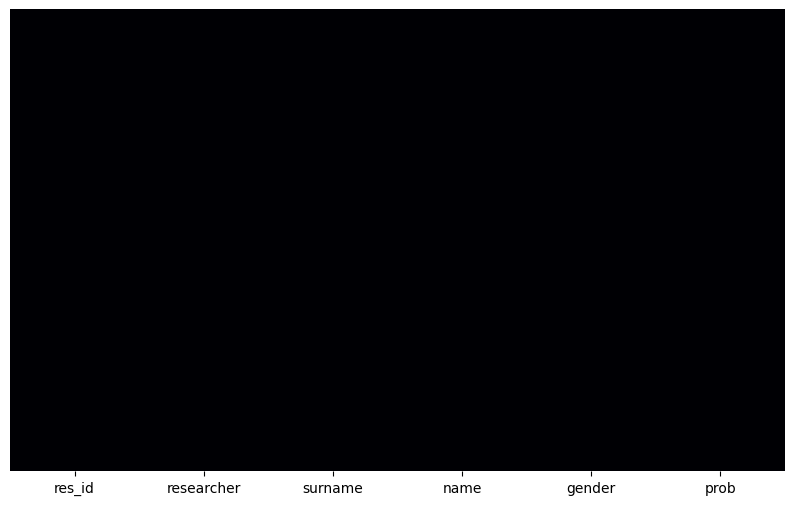

In [77]:
view_nan(researchers_df)

In [92]:
researchers_df.to_csv('../data/neuropapers_db/researchers.csv', index=False)